<a href="https://colab.research.google.com/github/carlm451/Gemstone_Images_Classification_Fine_Tuning/blob/main/Gemstones_Classifier_DenseNet121_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import os
import matplotlib.pyplot as plt
from random import shuffle 

#will use efficientnet ...hope it will be a pretrained model we can fine-tune easily 
from tensorflow.keras.applications.densenet import DenseNet121

In [2]:
# pulling gemstones data from kaggle
#!pip install kaggle

!mkdir ~/.kaggle

#need a kaggle API key kaggle.json
!mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download lsind18/gemstones-images

 96% 53.0M/55.2M [00:00<00:00, 179MB/s]
100% 55.2M/55.2M [00:00<00:00, 159MB/s]


In [3]:
!unzip gemstones-images.zip &> /dev/null  #suppress terminal output when unzipping images
!ls 

gemstones-images.zip  sample_data  test  train


In [4]:
#going to split of some of the training data for a validation data set
!mkdir val

In [5]:
import os

data_dir = '/content'

train_dir = os.path.join(data_dir,'train')

val_dir = os.path.join(data_dir,'val')

test_dir = os.path.join(data_dir,'test')

def count_img_samples(directory):
    
    count = 0
    
    for i,gem_type in enumerate(os.listdir(directory)):
        
        gem_dir = os.path.join(directory,gem_type)
    
        img_list = os.listdir(gem_dir)

        #print(f' dir {gem_dir} has {len(img_list)} images')

        count += len(img_list)
    
    return count

n_train = count_img_samples(train_dir)
n_test = count_img_samples(test_dir)
n_val = count_img_samples(val_dir)

print(f'{n_train=}, {n_val=}, {n_test=}')

n_train=2856, n_val=0, n_test=363


In [7]:
from random import shuffle

def partition_val_data(train_dir,val_dir,val_split=0.1):
    
    for gem_type in os.listdir(train_dir):
        
        train_gem_dir = os.path.join(train_dir,gem_type)
        
        img_list = os.listdir(train_gem_dir)
        
        shuffle(img_list)
        
        n_samples = round(len(img_list)*val_split)
        
        val_img_list = img_list[:n_samples] # take n_samples random images to move
        
        val_gem_dir = os.path.join(val_dir,gem_type)
        
        if not os.path.exists(val_gem_dir):
            
            os.mkdir(val_gem_dir)
            
            for gem_img in val_img_list:
                
                original_path = os.path.join(train_gem_dir,gem_img)
                
                destination_path = os.path.join(val_gem_dir,gem_img)
                
                os.rename(original_path,destination_path)
        
            #print(f'Moved {len(os.listdir(val_gem_dir))} training images from to {val_gem_dir}')
            
        else:
            
            pass
            #print(f'Val dir {val_gem_dir} has {len(os.listdir(val_gem_dir))} images')

In [8]:
val_split=0.15  # move 15% train to use for validation

partition_val_data(train_dir,val_dir,val_split)

In [9]:
n_train = count_img_samples(train_dir)
n_test = count_img_samples(test_dir)
n_val = count_img_samples(val_dir)

print(f'{n_train=}, {n_val=}, {n_test=}')

n_train=2434, n_val=422, n_test=363


In [10]:
from tensorflow.keras.utils import load_img, img_to_array

def get_img_array(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path)
    
    x = img_to_array(img) / 255.
    
    return x

def get_img_array_resized(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path,target_size=(224,224),keep_aspect_ratio=False)
    
    x = img_to_array(img) / 255.
    
    return x

In [11]:
!ls val

gem_types_list = os.listdir(val_dir)

n_classes = len(gem_types_list)

print(f'{n_classes} classes of gemstone')

 Alexandrite	      Chrysocolla     Larimar		 'Sapphire Blue'
 Almandine	      Chrysoprase     Malachite		 'Sapphire Pink'
 Amazonite	      Citrine	      Moonstone		 'Sapphire Purple'
 Amber		      Coral	      Morganite		 'Sapphire Yellow'
 Amethyst	      Danburite      'Onyx Black'	  Scapolite
 Ametrine	      Diamond	     'Onyx Green'	  Serpentine
 Andalusite	      Diaspore	     'Onyx Red'		  Sodalite
 Andradite	      Dumortierite    Opal		  Spessartite
 Aquamarine	      Emerald	      Pearl		  Sphene
'Aventurine Green'    Fluorite	      Peridot		  Spinel
'Aventurine Yellow'  'Garnet Red'     Prehnite		  Spodumene
 Benitoite	      Goshenite       Pyrite		  Sunstone
'Beryl Golden'	      Grossular       Pyrope		  Tanzanite
 Bixbite	      Hessonite      'Quartz Beer'	 'Tigers Eye'
 Bloodstone	      Hiddenite      'Quartz Lemon'	  Topaz
'Blue Lace Agate'     Iolite	     'Quartz Rose'	  Tourmaline
 Carnelian	      Jade	     'Quartz Rutilated'   Tsavorite
'Cats Eye'	      Jasper	     'Quartz 

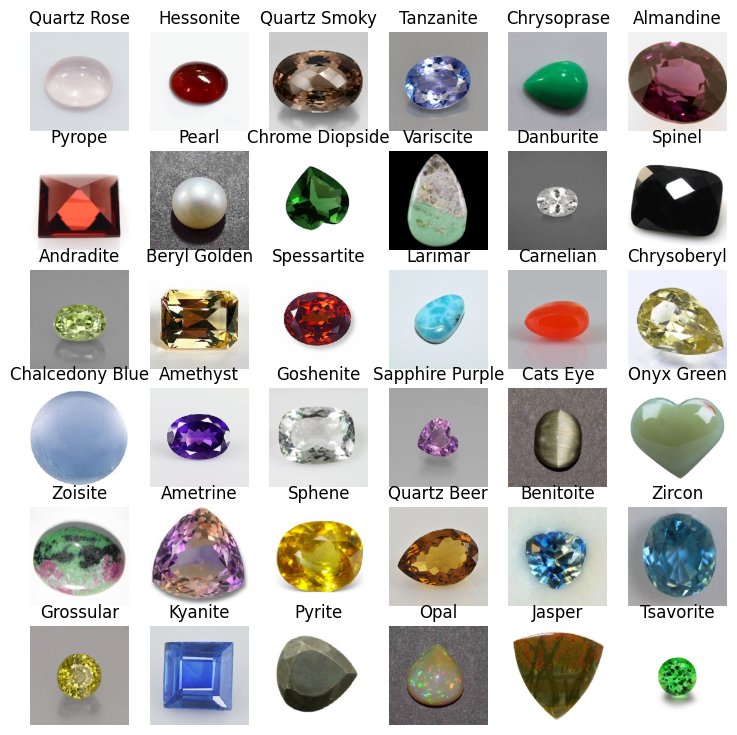

In [12]:
import matplotlib.pyplot as plt

shuffle(gem_types_list)

fig,axes=plt.subplots(6,6,figsize=(9,9))

count=0

for i in range(6):
  for j in range(6):

      gem_type=gem_types_list[count]

      sample_x = get_img_array(train_dir,gem_type)
      sample_x_resized = get_img_array_resized(train_dir,gem_type)

      axes[i,j].imshow(sample_x_resized)
      axes[i,j].set_axis_off()
      axes[i,j].set_title(f'{gem_type}')
      count+=1

plt.show()

In [13]:
# generators to stream images for training/validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range=90,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   zoom_range=0.5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

val_datagen  = ImageDataGenerator( rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    keep_aspect_ratio=False,
                                                    classes=gem_types_list) 

val_generator = val_datagen.flow_from_directory(val_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    keep_aspect_ratio=False,
                                                    classes=gem_types_list) 

Found 2434 images belonging to 87 classes.
Found 422 images belonging to 87 classes.


In [14]:
def get_uncompiled_model(n_classes, model_name,fine_tune=0):

    tf.keras.backend.clear_session()

    pretrained = DenseNet121(include_top=False, pooling='avg',input_shape=(224,224,3))

    if fine_tune > 0:
        for layer in pretrained.layers[:-fine_tune]:
            layer.trainable = False
    else:
        pretrained.trainable=False #freezes all children layers 

    inputs=tf.keras.layers.Input(shape=(224,224,3))

    x=pretrained(inputs,training=False)   #this is important for behavior of batch norm layers when fine-tuning

    x = tf.keras.layers.Dense(n_classes)(x)  # make sure to use from_logits=True in loss later on

    model = tf.keras.Model(inputs=inputs,outputs=x)
    
    return model

In [15]:
model_1 = get_uncompiled_model(n_classes,model_name='densenet121_base_frozen')
    
model_1.summary()

#checking that the input size is correct, should be (224,224,3)
model_1.input

29084464/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet121 (Functional)    (None, 1024)              7037504   
                                                                 
 dense (Dense)               (None, 87)                89175     
                                                                 
Total params: 7,126,679
Trainable params: 89,175
Non-trainable params: 7,037,504
_________________________________________________________________


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [16]:
base_learning_rate = 0.0005


model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [17]:
!rm -r training_1

!mkdir training_1

checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

N_EPOCHS=25

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history_1 = model_1.fit(
            train_generator,
            epochs=N_EPOCHS,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

rm: cannot remove 'training_1': No such file or directory
Epoch 1/25
39/39 [==============================] - ETA: 0s - loss: 4.4490 - categorical_accuracy: 0.0382
Epoch 1: saving model to training_1/cp-0001.ckpt
39/39 [==============================] - 59s 1s/step - loss: 4.4490 - categorical_accuracy: 0.0382 - val_loss: 4.0085 - val_categorical_accuracy: 0.1161
Epoch 2/25
39/39 [==============================] - ETA: 0s - loss: 3.8369 - categorical_accuracy: 0.1261
Epoch 2: saving model to training_1/cp-0002.ckpt
39/39 [==============================] - 38s 969ms/step - loss: 3.8369 - categorical_accuracy: 0.1261 - val_loss: 3.4963 - val_categorical_accuracy: 0.1943
Epoch 3/25
39/39 [==============================] - ETA: 0s - loss: 3.3881 - categorical_accuracy: 0.2412
Epoch 3: saving model to training_1/cp-0003.ckpt
39/39 [==============================] - 36s 931ms/step - loss: 3.3881 - categorical_accuracy: 0.2412 - val_loss: 3.1105 - val_categorical_accuracy: 0.2773
Epoch 4/25
3